![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/9784873119076/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

In [ ]:
!git clone https://github.com/Morzeux/HttpParamsDataset

Cloning into 'HttpParamsDataset'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


In [ ]:
!pip install optuna

     |████████████████████████████████| 302 kB 4.8 MB/s 
     |████████████████████████████████| 80 kB 8.0 MB/s 
     |████████████████████████████████| 208 kB 56.3 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 111 kB 74.5 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 144 kB 72.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=bcfedfae77d4a5e6b902cbb2a423a4c4b9bf5caf115f41aa67b6ea1e8278b458
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')

In [ ]:
import numpy as np
import pandas as pd

# HTTPクエリストリングのエントロピーの計算
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [ ]:
# 通常であるとラベリングされた行列のみを抽出
df_norm = df[df.attack_type == 'norm']

# 算出されたエントロピーを格納するリストを用意
norm_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_norm['payload']:
    
    # エントロピーの計算と代入
    norm_entropies.append(H_entropy(i))

In [ ]:
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [ ]:
# SQLインジェクションであるとラベリングされた行列のみを抽出
df_sqli = df[df.attack_type == 'sqli']

# 算出されたエントロピーを格納するリストを用意
sqli_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_sqli['payload']:
    
    # エントロピーの計算と代入
    sqli_entropies.append(H_entropy(i))

In [ ]:
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

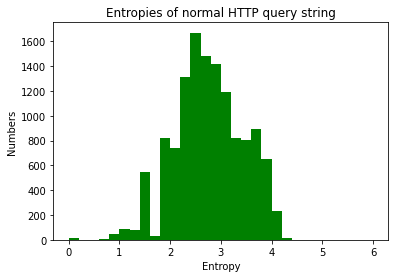

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show()

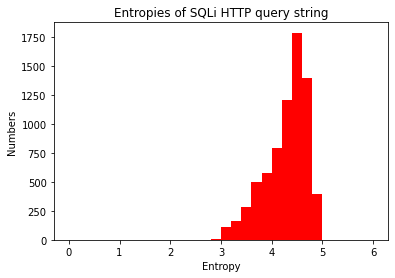

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of SQLi HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show()

In [ ]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

,payload,length,attack_type,label
291,1' where 6406=6406;select count(*) from rdb$fi...,115,sqli,anom
292,1) and 8514=(select count(*) from domain.domai...,111,sqli,anom
293,1) where 7956=7956 or sleep(5)#,31,sqli,anom
294,-7387'))) order by 1--,22,sqli,anom
295,"1))) union all select null,null,null#",37,sqli,anom
...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,anom
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,anom
20362,"1"" order by 1--",15,sqli,anom
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,anom


In [ ]:
print('{:.2%}'.format(df_sqli['payload'].str.contains('\)').sum() / len(df_sqli['payload'])))

90.91%


In [ ]:
df_norm = df[df.attack_type == 'norm']
print('{:.2%}'.format(df_norm['payload'].str.contains('\)').sum() / len(df_norm['payload'])))

0.01%


In [ ]:
def func_preprocessing(df):
    train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
    df = df[train_rows]

    # エントロピーと閉じ括弧の有無を入れる配列
    entropies = []
    closing_parenthesis = []
    
    # payload列からHTTPクエリストリングを取り出して処理させる
    for i in df['payload']:
        # エントロピーの計算と代入
        entropies.append(H_entropy(i))
        
        # 閉じ括弧を検出して、存在した場合は列closing_parenthesisに1を設定、ない場合は0を設定
        if i.count(')'):
            closing_parenthesis.append(1)
        else:
            closing_parenthesis.append(0)
    
    # データセットに新たに列を追加
    df = df.assign(entropy=entropies)
    df = df.assign(closing_parenthesis=closing_parenthesis)
    
    # データセットのlabel列のnormを0に、anormを1に変更
    rep = df.label.replace({"norm":0,"anom":1})
    df = df.assign(label=rep)
    
    return df

In [ ]:
df = func_preprocessing(df)

In [ ]:
# 交差検証を行うため、テスト用に分割されているデータも読み込んで単一の行列にする
# テストデータのロード
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')
test_data = func_preprocessing(test_data)

# 特徴量に使用する列のみを抽出
df_x = df[['length','entropy','closing_parenthesis']]
test_x = test_data[['length','entropy','closing_parenthesis']]

# ラベルのみを抽出
df_y = df[['label']]
test_y = test_data[['label']]

# 特徴量とラベルとして、それぞれひとつにまとめる
X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

In [ ]:
X_all

,length,entropy,closing_parenthesis
0,14,3.093069,0
1,12,3.022055,0
2,16,2.827820,0
3,5,2.321928,0
4,14,3.378783,0
...,...,...,...
10176,113,4.422041,1
10177,113,4.514233,1
10178,136,4.630369,1
10179,111,4.539371,1


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 64)
        }
        model = DecisionTreeClassifier(**params)
        # 交差検証の設定
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                cv=kf,
                                scoring='neg_log_loss',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2021-10-03 12:45:05,169] A new study created in memory with name: no-name-f93d6656-c1ca-4bca-95e6-c3a5838d6f00
[I 2021-10-03 12:45:06,615] Trial 0 finished with value: -0.47731562369704256 and parameters: {'criterion': 'entropy', 'max_depth': 23}. Best is trial 0 with value: -0.47731562369704256.
[I 2021-10-03 12:45:06,743] Trial 1 finished with value: -0.3664686625141009 and parameters: {'criterion': 'gini', 'max_depth': 13}. Best is trial 0 with value: -0.47731562369704256.
[I 2021-10-03 12:45:06,891] Trial 2 finished with value: -0.5050906971200649 and parameters: {'criterion': 'entropy', 'max_depth': 28}. Best is trial 2 with value: -0.5050906971200649.
[I 2021-10-03 12:45:07,019] Trial 3 finished with value: -0.5022637429302982 and parameters: {'criterion': 'gini', 'max_depth': 56}. Best is trial 2 with value: -0.5050906971200649.
[I 2021-10-03 12:45:07,166] Trial 4 finished with value: -0.444643489618387 and parameters: {'criterion': 'entropy', 'max_depth': 18}. Best is trial 

params: {'criterion': 'entropy', 'max_depth': 39}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#ハイパーパラメータチューニングで特定した値を設定

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accurary: 98.29244 %
[[3813   34]
 [  69 2116]]


In [ ]:
import pandas as pd

# データセットを再ロードする
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')

train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
df = df[train_rows]

test_train_rows = ((test_data.attack_type == 'norm') | (test_data.attack_type == 'sqli'))
test_data = test_data[test_train_rows]

df_y = df[['label']]
test_y = test_data[['label']]

df_x = df.iloc[:,:-1]
test_x = test_data.iloc[:,:-1]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

rep = y_all.label.replace({"norm":0,"anom":1})
y_all = y_all.assign(label=rep)

In [ ]:
X_all

,payload,length,attack_type
0,c/ caridad s/n,14,norm
1,"campello, el",12,norm
2,1442431887503330,16,norm
3,nue37,5,norm
4,tufts3@joll.rs,14,norm
...,...,...,...
10176,"1"") where 2367=2367;select (case when (4666=46...",113,sqli
10177,"1') and updatexml(3393,concat(0x2e,0x7171706a7...",113,sqli
10178,1') as tqdg where 9355=9355;select (case when ...,136,sqli
10179,"1') and extractvalue(7982,concat(0x5c,0x717170...",111,sqli


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_all['payload']
y = y_all

# ベクトル化のためのオプションの設定、文字を対象にユニグラムを行う
vec_opts = {
    "ngram_range": (1, 1), 
    "analyzer": "char", 
    "min_df" : 0.1
}

# TfidfVectorizerの初期化
v = TfidfVectorizer(**vec_opts)
# ベクトル化の実行
X = v.fit_transform(X)

In [ ]:
import numpy as np

# 特徴に使用されている文字を出力
features = v.get_feature_names()
np.array(features)

array([' ', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y'], dtype='<U1')

In [ ]:
df = pd.DataFrame(X.toarray())
df.columns = features
df

,,"""",',(,),*,",",-,.,0,1,2,3,4,5,6,7,8,9,=,a,b,c,d,e,f,g,h,i,k,l,m,n,o,p,r,s,t,u,v,w,x,y
0,0.453262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367518,0.000000,0.460722,0.504676,0.000000,0.000000,0.000000,0.000000,0.231185,0.000000,0.000000,0.000000,0.213771,0.000000,0.000000,0.209315,0.222629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.223881,0.000000,0.000000,0.000000,0.000000,0.000000,0.297448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181529,0.000000,0.227566,0.000000,0.379535,0.000000,0.000000,0.000000,0.000000,0.000000,0.637700,0.279457,0.000000,0.211999,0.320803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316555,0.257108,0.154605,0.637142,0.493407,0.150187,0.000000,0.165919,0.332115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.488536,0.000000,0.000000,0.000000,0.508881,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.342872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.381555,0.000000,0.000000,0.000000,0.000000,0.000000,0.489108,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382917,0.000000,0.000000,0.000000,0.259419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310430,0.000000,0.000000,0.000000,0.000000,0.407889,0.000000,0.000000,0.203400,0.000000,0.198388,0.422014,0.443910,0.259723,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30151,0.427799,0.061067,0.000000,0.132674,0.162360,0.062953,0.000000,0.096652,0.117327,0.000000,0.064151,0.077151,0.079487,0.164146,0.000000,0.562813,0.082797,0.000000,0.000000,0.086371,0.133412,0.046812,0.100347,0.073281,0.390506,0.047558,0.000000,0.131508,0.000000,0.000000,0.093734,0.082153,0.093121,0.031161,0.000000,0.091180,0.290938,0.170019,0.000000,0.000000,0.100595,0.000000,0.056381
30152,0.166014,0.000000,0.208435,0.267729,0.245725,0.000000,0.264680,0.000000,0.000000,0.159385,0.323633,0.038922,0.360899,0.000000,0.000000,0.121685,0.375929,0.000000,0.129710,0.087146,0.188453,0.000000,0.101248,0.110907,0.140718,0.000000,0.100469,0.000000,0.000000,0.000000,0.094575,0.041445,0.156594,0.031441,0.047577,0.000000,0.032617,0.137235,0.040147,0.000000,0.000000,0.369485,0.000000
30153,0.468956,0.000000,0.049065,0.126046,0.154249,0.059808,0.000000,0.000000,0.055733,0.000000,0.030473,0.183243,0.075516,0.000000,0.142405,0.381927,0.196652,0.000000,0.081423,0.082057,0.152097,0.000000,0.190669,0.069620,0.397499,0.090365,0.047301,0.208231,0.063784,0.000000,0.089051,0.117074,0.147448,0.088813,0.000000,0.144375,0.245693,0.226136,0.000000,0.000000,0.095570,0.000000,0.000000
30154,0.171542,0.000000,0.215375,0.276644,0.253907,0.000000,0.227911,0.000000,0.000000,0.164692,0.234086,0.120653,0.000000,0.000000,0.039068,0.083825,0.517929,0.129590,0.134029,0.090048,0.222546,0.000000,0.174366,0.152800,0.203565,0.000000,0.000000,0.000000,0.000000,0.121721,0.097724,0.000000,0.097085,0.032488,0.000000,0.031687,0.033703,0.177256,0.041484,0.188331,0.000000,0.254525,0.000000


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train, verbose_eval=100, early_stopping_rounds=100, folds=StratifiedKFold(n_splits=5))

# ハイパーパラメータ探索の実行
tuner.run()

[I 2021-10-03 12:46:06,144] A new study created in memory with name: no-name-61b6fe68-4772-470a-9389-e4e945da0c75
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00115086 + 0.000685716


feature_fraction, val_score: 0.001096:  14%|#4        | 1/7 [00:05<00:31,  5.30s/it]

[100]	cv_agg's binary_logloss: 0.00135099 + 0.000840922


feature_fraction, val_score: 0.001096:  29%|##8       | 2/7 [00:10<00:27,  5.52s/it]

[100]	cv_agg's binary_logloss: 0.00235411 + 0.00137145


feature_fraction, val_score: 0.001096:  43%|####2     | 3/7 [00:18<00:24,  6.23s/it]

[100]	cv_agg's binary_logloss: 0.00189494 + 0.00120489


feature_fraction, val_score: 0.001096:  57%|#####7    | 4/7 [00:24<00:19,  6.41s/it]

[100]	cv_agg's binary_logloss: 0.00117304 + 0.000764567


feature_fraction, val_score: 0.001096:  71%|#######1  | 5/7 [00:29<00:11,  5.79s/it]

[100]	cv_agg's binary_logloss: 0.00162055 + 0.000905295


feature_fraction, val_score: 0.001096:  86%|########5 | 6/7 [00:35<00:05,  5.91s/it]

[100]	cv_agg's binary_logloss: 0.00301344 + 0.0015852


num_leaves, val_score: 0.001096:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00113775 + 0.000728627


num_leaves, val_score: 0.001079:   5%|5         | 1/20 [00:13<04:10, 13.20s/it]

[100]	cv_agg's binary_logloss: 0.00113386 + 0.000723563


num_leaves, val_score: 0.001072:  10%|#         | 2/20 [00:20<02:50,  9.47s/it]

[100]	cv_agg's binary_logloss: 0.00113548 + 0.000731237


num_leaves, val_score: 0.001072:  15%|#5        | 3/20 [00:33<03:13, 11.37s/it]

[100]	cv_agg's binary_logloss: 0.00288363 + 0.000458443
[200]	cv_agg's binary_logloss: 0.00153417 + 0.000747328
[300]	cv_agg's binary_logloss: 0.0014989 + 0.00104775


num_leaves, val_score: 0.001072:  20%|##        | 4/20 [00:38<02:23,  8.96s/it]

[100]	cv_agg's binary_logloss: 0.0011462 + 0.000733366


num_leaves, val_score: 0.001072:  25%|##5       | 5/20 [00:46<02:06,  8.44s/it]

[100]	cv_agg's binary_logloss: 0.00114117 + 0.00072977


num_leaves, val_score: 0.001072:  30%|###       | 6/20 [01:00<02:26, 10.46s/it]

[100]	cv_agg's binary_logloss: 0.00113634 + 0.000731399


num_leaves, val_score: 0.001072:  35%|###5      | 7/20 [01:14<02:30, 11.57s/it]

[100]	cv_agg's binary_logloss: 0.00114207 + 0.000729601


num_leaves, val_score: 0.001072:  40%|####      | 8/20 [01:29<02:31, 12.59s/it]

[100]	cv_agg's binary_logloss: 0.00113386 + 0.000723563


num_leaves, val_score: 0.001072:  45%|####5     | 9/20 [01:36<01:58, 10.76s/it]

[100]	cv_agg's binary_logloss: 0.00114586 + 0.000724871


num_leaves, val_score: 0.001072:  50%|#####     | 10/20 [01:51<02:02, 12.26s/it]

[100]	cv_agg's binary_logloss: 0.0011337 + 0.000715701


num_leaves, val_score: 0.001072:  55%|#####5    | 11/20 [02:02<01:46, 11.79s/it]

[100]	cv_agg's binary_logloss: 0.00113386 + 0.000723563


num_leaves, val_score: 0.001072:  60%|######    | 12/20 [02:09<01:22, 10.27s/it]

[100]	cv_agg's binary_logloss: 0.00114599 + 0.000753862


num_leaves, val_score: 0.001072:  65%|######5   | 13/20 [02:17<01:07,  9.64s/it]

[100]	cv_agg's binary_logloss: 0.00154185 + 0.000722785
[200]	cv_agg's binary_logloss: 0.00167612 + 0.00129868


num_leaves, val_score: 0.001072:  70%|#######   | 14/20 [02:21<00:47,  8.00s/it]

[100]	cv_agg's binary_logloss: 0.00112895 + 0.000700197


num_leaves, val_score: 0.001072:  75%|#######5  | 15/20 [02:31<00:43,  8.61s/it]

[100]	cv_agg's binary_logloss: 0.0011015 + 0.00071767


num_leaves, val_score: 0.001042:  80%|########  | 16/20 [02:37<00:31,  7.85s/it]

[100]	cv_agg's binary_logloss: 0.00114568 + 0.00069247


num_leaves, val_score: 0.001042:  85%|########5 | 17/20 [02:43<00:21,  7.08s/it]

[100]	cv_agg's binary_logloss: 0.00113756 + 0.000728839


num_leaves, val_score: 0.001042:  90%|######### | 18/20 [02:55<00:17,  8.61s/it]

[100]	cv_agg's binary_logloss: 0.00112515 + 0.000690739


num_leaves, val_score: 0.001042:  95%|#########5| 19/20 [03:04<00:08,  8.89s/it]

[100]	cv_agg's binary_logloss: 0.0011384 + 0.000724852


bagging, val_score: 0.001042:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0012019 + 0.000779294


bagging, val_score: 0.001042:  10%|#         | 1/10 [00:06<00:58,  6.55s/it]

[100]	cv_agg's binary_logloss: 0.00119522 + 0.000764833


bagging, val_score: 0.001042:  20%|##        | 2/10 [00:12<00:51,  6.38s/it]

[100]	cv_agg's binary_logloss: 0.00116581 + 0.00065207


bagging, val_score: 0.001042:  30%|###       | 3/10 [00:19<00:46,  6.71s/it]

[100]	cv_agg's binary_logloss: 0.0011351 + 0.000831818


bagging, val_score: 0.001042:  40%|####      | 4/10 [00:26<00:41,  6.84s/it]

[100]	cv_agg's binary_logloss: 0.00120181 + 0.000752734


bagging, val_score: 0.001042:  50%|#####     | 5/10 [00:33<00:33,  6.77s/it]

[100]	cv_agg's binary_logloss: 0.001172 + 0.000803806


bagging, val_score: 0.001042:  60%|######    | 6/10 [00:40<00:26,  6.72s/it]

[100]	cv_agg's binary_logloss: 0.00125545 + 0.000745291


bagging, val_score: 0.001042:  70%|#######   | 7/10 [00:46<00:19,  6.58s/it]

[100]	cv_agg's binary_logloss: 0.0012615 + 0.000795213


bagging, val_score: 0.001042:  80%|########  | 8/10 [00:53<00:13,  6.62s/it]

[100]	cv_agg's binary_logloss: 0.00132168 + 0.000852963


bagging, val_score: 0.001042:  90%|######### | 9/10 [00:59<00:06,  6.52s/it]

[100]	cv_agg's binary_logloss: 0.00127785 + 0.000786797
[200]	cv_agg's binary_logloss: 0.00136783 + 0.00135223


feature_fraction_stage2, val_score: 0.001042:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00116712 + 0.00068418


feature_fraction_stage2, val_score: 0.001042:  17%|#6        | 1/6 [00:05<00:28,  5.74s/it]

[100]	cv_agg's binary_logloss: 0.00111632 + 0.000773593


feature_fraction_stage2, val_score: 0.001042:  33%|###3      | 2/6 [00:11<00:22,  5.62s/it]

[100]	cv_agg's binary_logloss: 0.0011307 + 0.000694249


feature_fraction_stage2, val_score: 0.001042:  50%|#####     | 3/6 [00:17<00:17,  5.78s/it]

[100]	cv_agg's binary_logloss: 0.00126857 + 0.000748713


feature_fraction_stage2, val_score: 0.001042:  67%|######6   | 4/6 [00:23<00:12,  6.02s/it]

[100]	cv_agg's binary_logloss: 0.00116879 + 0.000692724


feature_fraction_stage2, val_score: 0.001042:  83%|########3 | 5/6 [00:29<00:06,  6.09s/it]

[100]	cv_agg's binary_logloss: 0.00121444 + 0.000740575


regularization_factors, val_score: 0.001042:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00126849 + 0.000650873


regularization_factors, val_score: 0.001042:   5%|5         | 1/20 [00:03<01:11,  3.74s/it]

[100]	cv_agg's binary_logloss: 0.00109856 + 0.000721025


regularization_factors, val_score: 0.001042:  10%|#         | 2/20 [00:09<01:24,  4.69s/it]

[100]	cv_agg's binary_logloss: 0.00124806 + 0.000655354


regularization_factors, val_score: 0.001042:  15%|#5        | 3/20 [00:13<01:14,  4.41s/it]

[100]	cv_agg's binary_logloss: 0.00187978 + 0.000536143
[200]	cv_agg's binary_logloss: 0.00159483 + 0.00061589
[300]	cv_agg's binary_logloss: 0.00157319 + 0.00062109


regularization_factors, val_score: 0.001042:  20%|##        | 4/20 [00:18<01:17,  4.83s/it]

[100]	cv_agg's binary_logloss: 0.00137116 + 0.000587363
[200]	cv_agg's binary_logloss: 0.00142085 + 0.000732158


regularization_factors, val_score: 0.001042:  25%|##5       | 5/20 [00:23<01:11,  4.75s/it]

[100]	cv_agg's binary_logloss: 0.00115144 + 0.00074336


regularization_factors, val_score: 0.001042:  30%|###       | 6/20 [00:28<01:07,  4.82s/it]

[100]	cv_agg's binary_logloss: 0.00116813 + 0.000725218


regularization_factors, val_score: 0.001042:  35%|###5      | 7/20 [00:32<01:01,  4.73s/it]

[100]	cv_agg's binary_logloss: 0.00126377 + 0.000614797


regularization_factors, val_score: 0.001042:  40%|####      | 8/20 [00:37<00:55,  4.65s/it]

[100]	cv_agg's binary_logloss: 0.00125011 + 0.00069629


regularization_factors, val_score: 0.001042:  45%|####5     | 9/20 [00:41<00:51,  4.64s/it]

[100]	cv_agg's binary_logloss: 0.00156598 + 0.000605267
[200]	cv_agg's binary_logloss: 0.00147056 + 0.000733242


regularization_factors, val_score: 0.001042:  50%|#####     | 10/20 [00:47<00:48,  4.89s/it]

[100]	cv_agg's binary_logloss: 0.00112888 + 0.000748799


regularization_factors, val_score: 0.001042:  55%|#####5    | 11/20 [00:53<00:46,  5.19s/it]

[100]	cv_agg's binary_logloss: 0.00110727 + 0.000735452


regularization_factors, val_score: 0.001042:  60%|######    | 12/20 [01:00<00:46,  5.86s/it]

[100]	cv_agg's binary_logloss: 0.0011052 + 0.0007387


regularization_factors, val_score: 0.001041:  65%|######5   | 13/20 [01:06<00:40,  5.81s/it]

[100]	cv_agg's binary_logloss: 0.00110661 + 0.000737069


regularization_factors, val_score: 0.001041:  70%|#######   | 14/20 [01:11<00:34,  5.77s/it]

[100]	cv_agg's binary_logloss: 0.00110834 + 0.000737419


regularization_factors, val_score: 0.001041:  75%|#######5  | 15/20 [01:17<00:28,  5.74s/it]

[100]	cv_agg's binary_logloss: 0.00110273 + 0.000719752


regularization_factors, val_score: 0.001041:  80%|########  | 16/20 [01:23<00:22,  5.72s/it]

[100]	cv_agg's binary_logloss: 0.00110303 + 0.000727457


regularization_factors, val_score: 0.001041:  85%|########5 | 17/20 [01:28<00:16,  5.64s/it]

[100]	cv_agg's binary_logloss: 0.0011907 + 0.000713323


regularization_factors, val_score: 0.001041:  90%|######### | 18/20 [01:33<00:10,  5.43s/it]

[100]	cv_agg's binary_logloss: 0.00110029 + 0.000708132


regularization_factors, val_score: 0.001041:  95%|#########5| 19/20 [01:39<00:05,  5.46s/it]

[100]	cv_agg's binary_logloss: 0.00111372 + 0.000736413


min_data_in_leaf, val_score: 0.001041:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.00134931 + 0.000781195


min_data_in_leaf, val_score: 0.001041:  20%|##        | 1/5 [00:05<00:22,  5.67s/it]

[200]	cv_agg's binary_logloss: 0.00160833 + 0.00143442
[100]	cv_agg's binary_logloss: 0.00106903 + 0.000747342


min_data_in_leaf, val_score: 0.001016:  40%|####      | 2/5 [00:11<00:16,  5.66s/it]

[100]	cv_agg's binary_logloss: 0.0011556 + 0.000640987


min_data_in_leaf, val_score: 0.001016:  60%|######    | 3/5 [00:16<00:11,  5.61s/it]

[100]	cv_agg's binary_logloss: 0.00112084 + 0.000696845


min_data_in_leaf, val_score: 0.001016:  80%|########  | 4/5 [00:22<00:05,  5.66s/it]

[100]	cv_agg's binary_logloss: 0.00125815 + 0.000799472


min_data_in_leaf, val_score: 0.001016: 100%|##########| 5/5 [00:28<00:00,  5.63s/it]


In [ ]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9989841413010749
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.6055926159789167e-08, 'lambda_l2': 7.66432779011447e-06, 'num_leaves': 44, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.6055926159789167e-08
    lambda_l2: 7.66432779011447e-06
    num_leaves: 44
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定(このパラメータは参考値)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 戻り値は確率になっているので四捨五入する
pred_labels_lgb = np.rint(preds)
# 予測精度と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels_lgb)))
print(confusion_matrix(y_test, pred_labels_lgb))

Accurary: 99.96684 %
[[3847    0]
 [   2 2183]]


# 以下が７章の課題のコード

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def objective(trial):
    # 探索対象のハイパーパラメータを設定
    eta =  trial.suggest_loguniform('eta', 1e-8, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-8, 1.0)
    max_delta_step = trial.suggest_loguniform('max_delta_step', 1e-8, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.0, 1000.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 1000.0)


    regr = xgb.XGBRegressor(
        eta = eta,
        gamma = gamma,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        max_delta_step = max_delta_step,
        subsample = subsample,
        reg_lambda = reg_lambda,
        reg_alpha = reg_alpha
        )

    regr.fit(X_train, y_train)

    pred = regr.predict(X_test)
    pred_labels = np.rint(preds)

    accuracy = accuracy_score(y_test, pred_labels)
    return (1-accuracy)

study = optuna.create_study()
study.optimize(objective, n_trials=30)
# ベストのパラメーターの出力
print('Best params:', study.best_params)

[I 2021-10-03 12:54:01,320] A new study created in memory with name: no-name-0745d81f-4992-4ea7-86a1-aa920842f699


[12:54:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:05,213] Trial 0 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.23485225158730041, 'gamma': 0.21919050231670764, 'max_depth': 14, 'min_child_weight': 0.01515942380470655, 'max_delta_step': 0.386802781670313, 'subsample': 0.1703023157408503, 'reg_lambda': 550.4010320502056, 'reg_alpha': 158.9000644201991}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:06,165] Trial 1 finished with value: 0.0003315649867373649 and parameters: {'eta': 4.555859530781887e-05, 'gamma': 6.684422233691827e-07, 'max_depth': 7, 'min_child_weight': 0.011376709637247897, 'max_delta_step': 1.0177562370919813e-08, 'subsample': 0.02885139719439811, 'reg_lambda': 353.6074184297265, 'reg_alpha': 754.5612681842466}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:12,717] Trial 2 finished with value: 0.0003315649867373649 and parameters: {'eta': 4.505042478162852e-06, 'gamma': 1.307224263998537e-07, 'max_depth': 20, 'min_child_weight': 7.947508155814542e-05, 'max_delta_step': 3.709022797281267e-07, 'subsample': 0.4447390942492684, 'reg_lambda': 879.9243803182886, 'reg_alpha': 225.53893720462415}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:21,541] Trial 3 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0004619692643859808, 'gamma': 0.026977715779690752, 'max_depth': 15, 'min_child_weight': 0.07041326653228552, 'max_delta_step': 0.0002977968704363149, 'subsample': 0.6710765194960017, 'reg_lambda': 821.5216841207858, 'reg_alpha': 944.0919300871984}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:26,531] Trial 4 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.2221861177382003e-06, 'gamma': 1.016175212763662e-06, 'max_depth': 15, 'min_child_weight': 1.0203760676699044e-07, 'max_delta_step': 0.8297592471759907, 'subsample': 0.4028641545599425, 'reg_lambda': 531.7204910837675, 'reg_alpha': 439.36208596801055}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:37,313] Trial 5 finished with value: 0.0003315649867373649 and parameters: {'eta': 3.816921630962475e-06, 'gamma': 0.01311677393136403, 'max_depth': 20, 'min_child_weight': 8.17792503920779e-06, 'max_delta_step': 2.008103530787669e-05, 'subsample': 0.9181638954607244, 'reg_lambda': 657.9932708866343, 'reg_alpha': 50.604912126080315}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:47,471] Trial 6 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.003623943250650215, 'gamma': 1.4274550201258969e-05, 'max_depth': 8, 'min_child_weight': 0.004937776564228127, 'max_delta_step': 0.0017798831185896332, 'subsample': 0.8109268017900533, 'reg_lambda': 555.2129705530034, 'reg_alpha': 134.37325203808436}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:50,674] Trial 7 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0002670519224741577, 'gamma': 0.003797626790225328, 'max_depth': 7, 'min_child_weight': 3.142436366412262e-05, 'max_delta_step': 4.8480991479628915e-08, 'subsample': 0.2207924142763753, 'reg_lambda': 999.2608188401801, 'reg_alpha': 333.35820401288464}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:54:55,978] Trial 8 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0011785633612575329, 'gamma': 1.0544358145248492e-07, 'max_depth': 8, 'min_child_weight': 1.7027413951329726e-08, 'max_delta_step': 0.7809504097204132, 'subsample': 0.6230555418639269, 'reg_lambda': 144.84458053739445, 'reg_alpha': 450.59093171963104}. Best is trial 0 with value: 0.0003315649867373649.


[12:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:03,976] Trial 9 finished with value: 0.0003315649867373649 and parameters: {'eta': 8.670618362075798e-05, 'gamma': 0.00011754319863846288, 'max_depth': 6, 'min_child_weight': 2.528155118087902e-07, 'max_delta_step': 0.03314175326651144, 'subsample': 0.713625648915715, 'reg_lambda': 289.05395447191995, 'reg_alpha': 236.8825561061384}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:04,936] Trial 10 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.5344085814474699, 'gamma': 0.6099739730683957, 'max_depth': 1, 'min_child_weight': 0.512945377520005, 'max_delta_step': 6.604196661791301e-06, 'subsample': 0.02864561011465827, 'reg_lambda': 108.29553988622473, 'reg_alpha': 650.7951422179021}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:05,850] Trial 11 finished with value: 0.0003315649867373649 and parameters: {'eta': 3.823953529179017e-08, 'gamma': 8.2100880406128e-05, 'max_depth': 13, 'min_child_weight': 0.0032917632210200574, 'max_delta_step': 2.1470540755750817e-08, 'subsample': 0.01445289106037928, 'reg_lambda': 348.2344187884633, 'reg_alpha': 686.2109597133332}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:08,643] Trial 12 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.9317661445822364, 'gamma': 2.2665549629910687e-06, 'max_depth': 3, 'min_child_weight': 0.0035372710601276306, 'max_delta_step': 0.009149693142233285, 'subsample': 0.22035392435370763, 'reg_lambda': 355.5780747968998, 'reg_alpha': 902.1579924845438}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:13,383] Trial 13 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.022884270771428634, 'gamma': 0.38103628383289934, 'max_depth': 11, 'min_child_weight': 0.051913159475371076, 'max_delta_step': 1.625962362920636e-06, 'subsample': 0.24636793055855424, 'reg_lambda': 655.1920195128944, 'reg_alpha': 713.5457667069186}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:16,596] Trial 14 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.041372348453366146, 'gamma': 0.0009588731157861067, 'max_depth': 17, 'min_child_weight': 0.0006676244696631194, 'max_delta_step': 8.279137229756216e-05, 'subsample': 0.1251562317927809, 'reg_lambda': 425.69437528241514, 'reg_alpha': 784.8792722516166}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:22,530] Trial 15 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.934753963477321e-07, 'gamma': 1.1586039494390724e-08, 'max_depth': 11, 'min_child_weight': 0.8000521988439753, 'max_delta_step': 0.03218925742318285, 'subsample': 0.35164698942639594, 'reg_lambda': 223.69400677667522, 'reg_alpha': 548.0822932882897}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:23,657] Trial 16 finished with value: 0.0003315649867373649 and parameters: {'eta': 3.243856592197476e-05, 'gamma': 0.0003170019829864386, 'max_depth': 5, 'min_child_weight': 0.03965403591312815, 'max_delta_step': 4.147115451027056e-07, 'subsample': 0.09441048224341259, 'reg_lambda': 683.6924932890284, 'reg_alpha': 834.4550370382292}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:31,535] Trial 17 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.06282005183635433, 'gamma': 0.0021843075939690726, 'max_depth': 17, 'min_child_weight': 0.0004285297335025808, 'max_delta_step': 0.00012308639633380413, 'subsample': 0.5515245756628533, 'reg_lambda': 468.44939780111855, 'reg_alpha': 564.1450419682313}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:36,145] Trial 18 finished with value: 0.0003315649867373649 and parameters: {'eta': 1.1830726819577144e-08, 'gamma': 1.2360100253518202e-08, 'max_depth': 11, 'min_child_weight': 0.43979085571464027, 'max_delta_step': 0.0858109110123834, 'subsample': 0.3217359359732963, 'reg_lambda': 215.49158963145163, 'reg_alpha': 356.82948544740714}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:38,090] Trial 19 finished with value: 0.0003315649867373649 and parameters: {'eta': 4.273881717738561e-05, 'gamma': 0.05203761749446846, 'max_depth': 2, 'min_child_weight': 0.05072158608843384, 'max_delta_step': 1.9094797820133396e-07, 'subsample': 0.15591595649717602, 'reg_lambda': 689.2348695690592, 'reg_alpha': 849.3296042810617}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:46,061] Trial 20 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.07774025222706255, 'gamma': 0.12015895426479352, 'max_depth': 17, 'min_child_weight': 0.0003014365329604246, 'max_delta_step': 0.0010019956921984185, 'subsample': 0.5438131265999477, 'reg_lambda': 468.15771153899664, 'reg_alpha': 572.6947706265734}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:50,527] Trial 21 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.009582473101868104, 'gamma': 0.0026851503652017055, 'max_depth': 13, 'min_child_weight': 3.882742521138563e-06, 'max_delta_step': 0.12701488199556482, 'subsample': 0.33213450266152045, 'reg_lambda': 19.22935795360641, 'reg_alpha': 343.1012570848244}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:55:57,661] Trial 22 finished with value: 0.0003315649867373649 and parameters: {'eta': 3.362614673443367e-08, 'gamma': 0.09707011602256202, 'max_depth': 10, 'min_child_weight': 0.20672270136456908, 'max_delta_step': 0.2744738535499452, 'subsample': 0.27415657575207875, 'reg_lambda': 739.3597357541837, 'reg_alpha': 33.72718056528083}. Best is trial 0 with value: 0.0003315649867373649.


[12:55:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:56:05,444] Trial 23 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.1278267354953262, 'gamma': 0.08402369012465145, 'max_depth': 17, 'min_child_weight': 0.0005229298579611291, 'max_delta_step': 0.0018352097427300866, 'subsample': 0.521476656399098, 'reg_lambda': 583.614006369137, 'reg_alpha': 621.7719508591788}. Best is trial 0 with value: 0.0003315649867373649.


[12:56:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:56:12,563] Trial 24 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.006209878265824583, 'gamma': 0.008231298596184699, 'max_depth': 14, 'min_child_weight': 4.228259289948548e-06, 'max_delta_step': 0.003892225830293131, 'subsample': 0.44311986604628456, 'reg_lambda': 448.8984347716, 'reg_alpha': 301.7766007638857}. Best is trial 0 with value: 0.0003315649867373649.


[12:56:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:56:20,700] Trial 25 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0089124750205587, 'gamma': 0.12636544975873515, 'max_depth': 13, 'min_child_weight': 1.042991802610194e-06, 'max_delta_step': 0.18453938432808387, 'subsample': 0.29538566310592523, 'reg_lambda': 795.7434856828652, 'reg_alpha': 43.05201987385671}. Best is trial 0 with value: 0.0003315649867373649.


[12:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:56:28,015] Trial 26 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.30815172949278813, 'gamma': 0.9900805792782007, 'max_depth': 18, 'min_child_weight': 0.18004726529433157, 'max_delta_step': 0.01992823535855419, 'subsample': 0.4916729300098682, 'reg_lambda': 599.596103767769, 'reg_alpha': 150.70149302984228}. Best is trial 0 with value: 0.0003315649867373649.


[12:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:56:37,731] Trial 27 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.1678091592565998, 'gamma': 0.0077410258442265215, 'max_depth': 15, 'min_child_weight': 2.0480575107715313e-05, 'max_delta_step': 0.004349583421197902, 'subsample': 0.7888601925290122, 'reg_lambda': 596.5730246333655, 'reg_alpha': 255.483870554711}. Best is trial 0 with value: 0.0003315649867373649.


[12:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:56:48,964] Trial 28 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.0043758462223211425, 'gamma': 0.24901564212646618, 'max_depth': 14, 'min_child_weight': 1.297020276410543e-06, 'max_delta_step': 0.24088338875756635, 'subsample': 0.4047223300903018, 'reg_lambda': 801.9631857442182, 'reg_alpha': 108.57344689604291}. Best is trial 0 with value: 0.0003315649867373649.


[12:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-03 12:56:53,014] Trial 29 finished with value: 0.0003315649867373649 and parameters: {'eta': 0.34680072946063256, 'gamma': 0.9078517361408194, 'max_depth': 19, 'min_child_weight': 0.018271377576020133, 'max_delta_step': 0.025046942311846242, 'subsample': 0.18305298390355476, 'reg_lambda': 963.1948580613326, 'reg_alpha': 179.8079222792345}. Best is trial 0 with value: 0.0003315649867373649.


Best params: {'eta': 0.23485225158730041, 'gamma': 0.21919050231670764, 'max_depth': 14, 'min_child_weight': 0.01515942380470655, 'max_delta_step': 0.386802781670313, 'subsample': 0.1703023157408503, 'reg_lambda': 550.4010320502056, 'reg_alpha': 158.9000644201991}


In [ ]:
optimised_model = xgb.XGBRegressor(
    eta = study.best_params['eta'],
    gamma = study.best_params['gamma'],
    max_depth = study.best_params['max_depth'],
    min_child_weight = study.best_params['min_child_weight'],
    max_delta_step = study.best_params['max_delta_step'],
    subsample = study.best_params['subsample'],
    reg_lambda = study.best_params['reg_lambda'],
    reg_alpha = study.best_params['reg_alpha']
    )

optimised_model.fit(X_train, y_train)

# テスト用データを使って予測する
pred_labels_xgb = optimised_model.predict(X_test)
# 返り値は確率になっているので四捨五入する
pred_labels_xgb_round = np.rint(preds)
# 予測精度と混同行列の出力
print("Accurary: {:.5f} %".format(
    100 * accuracy_score(y_test, pred_labels_xgb_round)
    )
)
print(confusion_matrix(y_test, pred_labels_xgb_round))

[12:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accurary: 99.96684 %
[[3847    0]
 [   2 2183]]


In [ ]:
preds_ans = pred_labels_lgb * 0.5 + pred_labels_xgb * 0.5

In [ ]:
print("Accurary: {:.5f} %".format(
    100 * accuracy_score(y_test, np.rint(preds_ans))
    )
)
print(confusion_matrix(y_test, np.rint(preds_ans)))

Accurary: 99.96684 %
[[3847    0]
 [   2 2183]]
